In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
import csv
import random
import time
import math
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as utils
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets

from random import shuffle
from collections import defaultdict
from copy import deepcopy
from itertools import chain

from __future__ import print_function
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from google.colab import files

In [0]:
'''
Reading MNIST dataset
'''

valid_size = 0.166666
batch_size = 128

# It converts the datapoints into tensor and then normalise each datapoint with given mean and standard deviation 
transform = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize([0.5,], [0.5,])])

# Loading the  MNIST dataset consisting of 60000 grayscale training images and 10000 grayscale testing images of size 28 X 28 pixels in a batch size of 128 images at a time
# and performing the above transformations 
# Randomly splitting data into 50000 training examples and 10000 validation examples by generating 50000 random unique indices in the range [0,59999] and then retreiving the values at those indices for building the training dataset. The values at remaining indices are used for building validation dataset.
trainset_mnist = datasets.MNIST('./', train=True, transform=transform, download=True)
num_train = len(trainset_mnist)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=batch_size, sampler=train_sampler)
validloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=batch_size, sampler=valid_sampler)


testset_mnist = torchvision.datasets.MNIST(root='./', train=False, download=True, transform=transform)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=128, shuffle=False)

In [0]:
# The below code implements Optimizer class and is taken from pytorch's github implementation

required = object()


class Optimizer(object):
    """Base class for all optimizers.

    Arguments:
        params (iterable): an iterable of :class:`Variable` s or
            :class:`dict` s. Specifies what Variables should be optimized.
        defaults: (dict): a dict containing default values of optimization
            options (used when a parameter group doesn't specify them).
    """

    def __init__(self, params, defaults):
        self.defaults = defaults

        if isinstance(params, Variable) or torch.is_tensor(params):
            raise TypeError("params argument given to the optimizer should be "
                            "an iterable of Variables or dicts, but got " +
                            torch.typename(params))

        self.state = defaultdict(dict)
        self.param_groups = []

        param_groups = list(params)
        if len(param_groups) == 0:
            raise ValueError("optimizer got an empty parameter list")
        if not isinstance(param_groups[0], dict):
            param_groups = [{'params': param_groups}]

        for param_group in param_groups:
            self.add_param_group(param_group)

    def __getstate__(self):
        return {
            'state': self.state,
            'param_groups': self.param_groups,
        }

    def __setstate__(self, state):
        self.__dict__.update(state)

    def state_dict(self):
        """Returns the state of the optimizer as a :class:`dict`.

        It contains two entries:

        * state - a dict holding current optimization state. Its content
            differs between optimizer classes.
        * param_groups - a dict containing all parameter groups
        """
        # Save ids instead of Variables
        def pack_group(group):
            packed = {k: v for k, v in group.items() if k != 'params'}
            packed['params'] = [id(p) for p in group['params']]
            return packed
        param_groups = [pack_group(g) for g in self.param_groups]
        # Remap state to use ids as keys
        packed_state = {(id(k) if isinstance(k, Variable) else k): v
                        for k, v in self.state.items()}
        return {
            'state': packed_state,
            'param_groups': param_groups,
        }

    def load_state_dict(self, state_dict):
        """Loads the optimizer state.

        Arguments:
            state_dict (dict): optimizer state. Should be an object returned
                from a call to :meth:`state_dict`.
        """
        # deepcopy, to be consistent with module API
        state_dict = deepcopy(state_dict)
        # Validate the state_dict
        groups = self.param_groups
        saved_groups = state_dict['param_groups']

        if len(groups) != len(saved_groups):
            raise ValueError("loaded state dict has a different number of "
                             "parameter groups")
        param_lens = (len(g['params']) for g in groups)
        saved_lens = (len(g['params']) for g in saved_groups)
        if any(p_len != s_len for p_len, s_len in zip(param_lens, saved_lens)):
            raise ValueError("loaded state dict contains a parameter group "
                             "that doesn't match the size of optimizer's group")

        # Update the state
        id_map = {old_id: p for old_id, p in
                  zip(chain(*(g['params'] for g in saved_groups)),
                      chain(*(g['params'] for g in groups)))}
        state = defaultdict(
            dict, {id_map.get(k, k): v for k, v in state_dict['state'].items()})

        # Update parameter groups, setting their 'params' value
        def update_group(group, new_group):
            new_group['params'] = group['params']
            return new_group
        param_groups = [
            update_group(g, ng) for g, ng in zip(groups, saved_groups)]
        self.__setstate__({'state': state, 'param_groups': param_groups})

    def zero_grad(self):
        """Clears the gradients of all optimized :class:`Variable` s."""
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    if p.grad.volatile:
                        p.grad.data.zero_()
                    else:
                        data = p.grad.data
                        p.grad = Variable(data.new().resize_as_(data).zero_())

    def step(self, closure):
        """Performs a single optimization step (parameter update).

        Arguments:
            closure (callable): A closure that reevaluates the model and
                returns the loss. Optional for most optimizers.
        """
        raise NotImplementedError

    def add_param_group(self, param_group):
        """Add a param group to the :class:`Optimizer` s `param_groups`.

        This can be useful when fine tuning a pre-trained network as frozen layers can be made
        trainable and added to the :class:`Optimizer` as training progresses.

        Arguments:
            param_group (dict): Specifies what Variables should be optimized along with group
            specific optimization options.
        """
        assert isinstance(param_group, dict), "param group must be a dict"

        params = param_group['params']
        if isinstance(params, Variable):
            param_group['params'] = [params]
        else:
            param_group['params'] = list(params)

        for param in param_group['params']:
            if not isinstance(param, Variable):
                raise TypeError("optimizer can only optimize Variables, "
                                "but one of the params is " + torch.typename(param))
            if not param.requires_grad:
                raise ValueError("optimizing a parameter that doesn't require gradients")
            if not param.is_leaf:
                raise ValueError("can't optimize a non-leaf Variable")

        for name, default in self.defaults.items():
            if default is required and name not in param_group:
                raise ValueError("parameter group didn't specify a value of required optimization parameter " +
                                 name)
            else:
                param_group.setdefault(name, default)

        param_set = set()
        for group in self.param_groups:
            param_set.update(set(group['params']))

        if not param_set.isdisjoint(set(param_group['params'])):
            raise ValueError("some parameters appear in more than one parameter group")

        self.param_groups.append(param_group)


In [0]:
# The below code modifies pytorch implementation of Adams optimizer to implement Amsgrad algorithm 

class Amsgrad(Optimizer):
    """Implements Amsgrad algorithm.

    It has been proposed in `On the Convergence of Adam and Beyond`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)

    .. _n the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    # constructor to initialize the hyper-parameters
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.99), eps=1e-8,
                 weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay)
        super(Amsgrad, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Amsgrad does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    # Maximum exponential moving average of squared gradient values
                    state['exp_avg_sq_maximum'] = torch.zeros_like(p.data)
                exp_avg, exp_avg_sq, exp_avg_sq_maximum = state['exp_avg'], state['exp_avg_sq'], state['exp_avg_sq_maximum']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

               # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                
                # Calculate the maximum between the previous maximum exponential average of squared gradients and current value
                exp_avg_sq_maximum = torch.max(exp_avg_sq_maximum,exp_avg_sq)

                # Store the maximum
                state['exp_avg_sq_maximum'] = exp_avg_sq_maximum
                
                
                denom = exp_avg_sq_maximum.sqrt().add_(group['eps'])

                step_size = group['lr']
                
                # Performs update on parameters of the network based on gradients
                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss


In [0]:
# Neural net architecture consisting of one hidden layer with 100 ReLu activation units and 1 output layer with 10 output units
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
def adjust_learning_rate(optimizer,lr,t):
    new_lr = lr/np.sqrt(t)
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

In [0]:
# Instanstiating the network on GPU
net = NeuralNet()
initial_state = net.state_dict()
net = net.cuda()
num_batches_train = int((1-valid_size)*num_train/batch_size)
num_batches_valid = int(valid_size*num_train/batch_size)

In [104]:
num_batches_train, num_batches_valid

(390, 78)

In [0]:
# Learning the parameters using Amsgrad optimization with categorical cross-entropy loss. The learning rate is initially set to 0.001.

criterion = nn.CrossEntropyLoss()

modulo = 128
# alphas = np.logspace(-1,-4,10)
alphas = [1e-3]
betas = [0.99, 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999]
# betas = [0.995]

In [0]:
# The function validation_loss() calculates the loss on validation data which is shuffled and passed to the network in batch size of 128 instances after every epoch.
def validation_loss_amsgrad():
  running_valid_loss = 0.0
  for i, data in enumerate(validloader_mnist, 0):
      inputs, labels = data
      inputs = inputs.float()
      labels = labels.long()
      inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

      inputs.unsqueeze_(1)
      valid_output = net(inputs)
      loss_valid = criterion(valid_output, labels)

      # print statistics
      running_valid_loss += loss_valid.data[0]
   
  return (running_valid_loss / num_batches_valid)

In [107]:
#@title Default title text
#The code below runs for 25 epochs, learns the parameters of the model using Amsgrad optimizer with cross-entropy loss function 
#and propagates back the gradients in the network. It prints the train loss after every 800 mini-batches for an epoch and validation loss after each epoch.



import timeit

train_loss_list = []
for alpha in alphas:
  for beta in betas:
    train_loss_list.append([[], alpha,beta, -1])

pkl_filename = 'nn_saved_model.pkl'
num_epochs = 13
total_iters = len(alphas)*len(betas)

param_count = 0
for alpha in alphas:

  for beta in betas:
    print("alpha:", alpha, " beta: ", beta)
    print("Iter:", param_count+1, "/", total_iters)
    train_loss_list[param_count][1] = alpha
    train_loss_list[param_count][2] = beta
    # Instanstiating the network on GPU
    net = NeuralNet()
    initial_state = net.state_dict()
    net = net.cuda()
    optimizer = Amsgrad(net.parameters(), lr=alpha, betas=(0.9,beta))
    t=0
    total_loss = 0
    iterations = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        start_time = timeit.default_timer()
        for i, data in enumerate(trainloader_mnist, 0):
            iterations += 1
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.data[0]
            loss.backward()
            optimizer.step()

#             adjust_learning_rate(optimizer,alpha,t)

            # print statistics
            train_loss_list[param_count][0].append(total_loss/iterations)


        print ('Epoch: %d Train loss: %.3f' %(epoch + 1, total_loss/iterations))
        elapsed = timeit.default_timer() - start_time
        print("Time for epoch: ", elapsed)
        torch.save(net.state_dict(), pkl_filename)
    
    train_loss_list[param_count][3] = validation_loss_amsgrad()
        
    param_count += 1

print('Finished Training')

alpha: 0.001  beta:  0.99
Iter: 1 / 10
Epoch: 1 Train loss: 0.448
Time for epoch:  6.676684580000256
Epoch: 2 Train loss: 0.366
Time for epoch:  6.590999633999672
Epoch: 3 Train loss: 0.323
Time for epoch:  6.599059221999596
Epoch: 4 Train loss: 0.293
Time for epoch:  6.583615930999258
Epoch: 5 Train loss: 0.271
Time for epoch:  6.622293626999635
Epoch: 6 Train loss: 0.253
Time for epoch:  6.666831956000351
Epoch: 7 Train loss: 0.237
Time for epoch:  6.5817856929998015
Epoch: 8 Train loss: 0.225
Time for epoch:  6.519144846999552
Epoch: 9 Train loss: 0.213
Time for epoch:  6.460794104999877
Epoch: 10 Train loss: 0.204
Time for epoch:  6.508748909999667
Epoch: 11 Train loss: 0.195
Time for epoch:  6.521792230999381
Epoch: 12 Train loss: 0.187
Time for epoch:  6.502059499000097
Epoch: 13 Train loss: 0.180
Time for epoch:  6.454354995000358
alpha: 0.001  beta:  0.991
Iter: 2 / 10
Epoch: 1 Train loss: 0.426
Time for epoch:  6.4911030439998285
Epoch: 2 Train loss: 0.343
Time for epoch:  6.4

Epoch: 1 Train loss: 0.407
Time for epoch:  6.589429705999464
Epoch: 2 Train loss: 0.327
Time for epoch:  6.5925407029999405
Epoch: 3 Train loss: 0.284
Time for epoch:  6.590273034000347
Epoch: 4 Train loss: 0.255
Time for epoch:  6.585356331000185
Epoch: 5 Train loss: 0.233
Time for epoch:  6.602191310000308
Epoch: 6 Train loss: 0.216
Time for epoch:  6.615623108999898
Epoch: 7 Train loss: 0.202
Time for epoch:  6.6991903320003985
Epoch: 8 Train loss: 0.190
Time for epoch:  6.678153847999965
Epoch: 9 Train loss: 0.180
Time for epoch:  6.632117836999896
Epoch: 10 Train loss: 0.171
Time for epoch:  6.522155962999932
Epoch: 11 Train loss: 0.163
Time for epoch:  6.481146394000461
Epoch: 12 Train loss: 0.156
Time for epoch:  6.49937252700056
Epoch: 13 Train loss: 0.149
Time for epoch:  6.556872315999499
alpha: 0.001  beta:  0.995
Iter: 6 / 10
Epoch: 1 Train loss: 0.403
Time for epoch:  6.539858210999228
Epoch: 2 Train loss: 0.321
Time for epoch:  6.580646451000575
Epoch: 3 Train loss: 0.27

Epoch: 1 Train loss: 0.391
Time for epoch:  6.666615283000283
Epoch: 2 Train loss: 0.308
Time for epoch:  6.705126326000027
Epoch: 3 Train loss: 0.264
Time for epoch:  6.625607581000622
Epoch: 4 Train loss: 0.236
Time for epoch:  6.6375331899998855
Epoch: 5 Train loss: 0.215
Time for epoch:  6.6433010009996
Epoch: 6 Train loss: 0.199
Time for epoch:  6.678623744000106
Epoch: 7 Train loss: 0.185
Time for epoch:  6.674305552999613
Epoch: 8 Train loss: 0.175
Time for epoch:  6.723985151999841
Epoch: 9 Train loss: 0.165
Time for epoch:  6.689151665999816
Epoch: 10 Train loss: 0.157
Time for epoch:  6.685213269000087
Epoch: 11 Train loss: 0.150
Time for epoch:  6.661488413999905
Epoch: 12 Train loss: 0.144
Time for epoch:  6.573318429999745
Epoch: 13 Train loss: 0.138
Time for epoch:  6.596872125999653
alpha: 0.001  beta:  0.999
Iter: 10 / 10
Epoch: 1 Train loss: 0.391
Time for epoch:  6.687677492000148
Epoch: 2 Train loss: 0.311
Time for epoch:  6.705271601000277
Epoch: 3 Train loss: 0.270

In [0]:
# Once the network is fully trained, prediction is made on the training data and the results are compared against the actual labels
input_classes = []
actual_labels = []
for i, data in enumerate(trainloader_mnist, 0):
  inputs, labels = data 
  inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
  inputs.unsqueeze_(1)
  train_out = net(inputs)
  _, train_classes = torch.max(train_out, 1)
  train_classes_np = train_classes.data.cpu().numpy()
  input_classes.append(train_classes_np)
  actual_labels.append(labels.data.cpu().numpy())

In [0]:
inp_ = [j for i in input_classes for j in i]
lab_ = [j for i in actual_labels for j in i]

In [110]:
print ("Train Accuracy = ", sum(np.array(inp_) == np.array(lab_))/500)

Train Accuracy =  97.726


In [0]:
def valid_accuracy():
  # Once the network is fully trained, prediction is made on the validation data and the results are compared against the actual labels
  input_classes_valid = []
  actual_labels_valid = []
  for i, data in enumerate(validloader_mnist, 0):
    inputs, labels = data
    inputs = inputs.float()
    labels = labels.long()
    inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

    inputs.unsqueeze_(1)
    valid_out = net(inputs)
    _, valid_classes = torch.max(valid_out, 1)
    valid_classes_np = valid_classes.data.cpu().numpy()
    input_classes_valid.append(valid_classes_np)
    actual_labels_valid.append(labels.data.cpu().numpy())
  inp_valid = [j for i in input_classes_valid for j in i]
  lab_valid = [j for i in actual_labels_valid for j in i]
  accuracy = sum(np.array(inp_valid) == np.array(lab_valid))/100
  return accuracy

In [0]:
# Instanstiating the network on GPU
net_adam = NeuralNet()
net_adam.load_state_dict(initial_state)
net_adam = net_adam.cuda()

In [0]:
# Learning the parameters using Amsgrad optimization with categorical cross-entropy loss. The learning rate is initially set to 0.001.
criterion_adam = nn.CrossEntropyLoss()


In [0]:
# The function validation_loss() calculates the loss on validation data which is shuffled and passed to the network in batch size of 128 instances after every epoch.
def validation_loss_adam():
  running_valid_loss = 0.0
  for i, data in enumerate(validloader_mnist, 0):
      inputs, labels = data
      inputs = inputs.float()
      labels = labels.long()
      inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

      inputs.unsqueeze_(1)
      valid_output = net_adam(inputs)
      loss_valid = criterion_adam(valid_output, labels)

      # print statistics
      running_valid_loss += loss_valid.data[0]
   
  return (running_valid_loss / num_batches_valid)

In [115]:
#The code below runs for 25 epochs, learns the parameters of the model using Amsgrad optimizer with cross-entropy loss function 
#and propagates back the gradients in the network. It prints the train loss after every 800 mini-batches for an epoch and validation loss after each epoch.


train_loss_adam_list = []
for alpha in alphas:
  for beta in betas:
    train_loss_adam_list.append([[], alpha,beta, -1])

total_iters = len(alphas)*len(betas)

pkl_filename = 'nn_saved_model_adam.pkl'
total_loss = 0
iterations = 0
param_count = 0
for alpha in alphas:
  for beta in betas:
    train_loss_adam_list[param_count][1] = alpha
    train_loss_adam_list[param_count][2] = beta
    print("Iter:", param_count+1, "/", total_iters)
    print("alpha:", alpha, " beta: ", beta)
    net_adam = NeuralNet()
    initial_state = net_adam.state_dict()
    net_adam = net_adam.cuda()
    optimizer_adam = optim.Adam(net_adam.parameters(), lr=alpha, betas=(0.9,beta))   
    t=0
    total_loss = 0
    iterations = 0
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        start_time = timeit.default_timer()
        running_loss_train = 0.0
        for i, data in enumerate(trainloader_mnist, 0):
            iterations += 1
            # get the inputs
            inputs, labels = data

            # wrap them in Variable
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            # zero the parameter gradients
            optimizer_adam.zero_grad()

            # forward + backward + optimize
            outputs = net_adam(inputs)
            loss = criterion_adam(outputs, labels)
            total_loss += loss.data[0]
            loss.backward()
            optimizer_adam.step()
#             adjust_learning_rate(optimizer_adam,alpha,t)

            # print statistics
            train_loss_adam_list[param_count][0].append(total_loss/iterations)
    
    
            

        print('Epoch: %d Train loss: %.3f' %(epoch + 1, total_loss/iterations))
        elapsed = timeit.default_timer() - start_time
        print("time for epoch: ", elapsed)
        torch.save(net_adam.state_dict(), pkl_filename)
        
    train_loss_adam_list[param_count][3] = validation_loss_adam()
    param_count += 1

print('Finished Training')

Iter: 1 / 10
alpha: 0.001  beta:  0.99
Epoch: 1 Train loss: 0.484
time for epoch:  6.67291899600059
Epoch: 2 Train loss: 0.371
time for epoch:  6.652709254999536
Epoch: 3 Train loss: 0.311
time for epoch:  6.6002123020007275
Epoch: 4 Train loss: 0.271
time for epoch:  6.570110535999447
Epoch: 5 Train loss: 0.242
time for epoch:  6.537203382999905
Epoch: 6 Train loss: 0.220
time for epoch:  6.514847268999802
Epoch: 7 Train loss: 0.202
time for epoch:  6.468917942000189
Epoch: 8 Train loss: 0.187
time for epoch:  6.484750437999537
Epoch: 9 Train loss: 0.175
time for epoch:  6.471425673999875
Epoch: 10 Train loss: 0.165
time for epoch:  6.499204218000159
Epoch: 11 Train loss: 0.156
time for epoch:  6.411486527999841
Epoch: 12 Train loss: 0.147
time for epoch:  6.394121720999465
Epoch: 13 Train loss: 0.140
time for epoch:  6.422954427999684
Iter: 2 / 10
alpha: 0.001  beta:  0.991
Epoch: 1 Train loss: 0.471
time for epoch:  6.384430866000002
Epoch: 2 Train loss: 0.363
time for epoch:  6.459

Epoch: 1 Train loss: 0.480
time for epoch:  6.502954881999358
Epoch: 2 Train loss: 0.373
time for epoch:  6.51598985199962
Epoch: 3 Train loss: 0.316
time for epoch:  6.514656874999673
Epoch: 4 Train loss: 0.278
time for epoch:  6.532800758000121
Epoch: 5 Train loss: 0.250
time for epoch:  6.497186640000109
Epoch: 6 Train loss: 0.228
time for epoch:  6.50211892400057
Epoch: 7 Train loss: 0.210
time for epoch:  6.502968234000036
Epoch: 8 Train loss: 0.195
time for epoch:  6.52510034199986
Epoch: 9 Train loss: 0.183
time for epoch:  6.5014173700001265
Epoch: 10 Train loss: 0.172
time for epoch:  6.512407903000167
Epoch: 11 Train loss: 0.162
time for epoch:  6.49237368500053
Epoch: 12 Train loss: 0.154
time for epoch:  6.494030822999775
Epoch: 13 Train loss: 0.147
time for epoch:  6.489195690000088
Iter: 6 / 10
alpha: 0.001  beta:  0.995
Epoch: 1 Train loss: 0.485
time for epoch:  6.466698240000369
Epoch: 2 Train loss: 0.377
time for epoch:  6.506582402999811
Epoch: 3 Train loss: 0.320
ti

Epoch: 1 Train loss: 0.476
time for epoch:  6.439986288999535
Epoch: 2 Train loss: 0.371
time for epoch:  6.437930610999501
Epoch: 3 Train loss: 0.316
time for epoch:  6.535770558999502
Epoch: 4 Train loss: 0.278
time for epoch:  6.542264339000212
Epoch: 5 Train loss: 0.249
time for epoch:  6.524686245000339
Epoch: 6 Train loss: 0.227
time for epoch:  6.541983287999756
Epoch: 7 Train loss: 0.210
time for epoch:  6.582698057000016
Epoch: 8 Train loss: 0.195
time for epoch:  6.519777470999543
Epoch: 9 Train loss: 0.182
time for epoch:  6.526350631000241
Epoch: 10 Train loss: 0.172
time for epoch:  6.509317640000518
Epoch: 11 Train loss: 0.162
time for epoch:  6.476774814000237
Epoch: 12 Train loss: 0.154
time for epoch:  6.515498916998695
Epoch: 13 Train loss: 0.147
time for epoch:  6.472753777999969
Iter: 10 / 10
alpha: 0.001  beta:  0.999
Epoch: 1 Train loss: 0.479
time for epoch:  6.497318097000971
Epoch: 2 Train loss: 0.378
time for epoch:  6.512736299000608
Epoch: 3 Train loss: 0.32

In [0]:
# # Once the network is fully trained, prediction is made on the validation data and the results are compared against the actual labels
# input_classes_valid = []
# actual_labels_valid = []
# for i, data in enumerate(validloader_mnist, 0):
#   inputs, labels = data
#   inputs = inputs.float()
#   labels = labels.long()
#   inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

#   inputs.unsqueeze_(1)
#   valid_out = net_adam(inputs)
#   _, valid_classes = torch.max(valid_out, 1)
#   valid_classes_np = valid_classes.data.cpu().numpy()
#   input_classes_valid.append(valid_classes_np)
#   actual_labels_valid.append(labels.data.cpu().numpy())
#   inp_valid = [j for i in input_classes_valid for j in i]
#   lab_valid = [j for i in actual_labels_valid for j in i]
#   print ("Valid Accuracy = ", sum(np.array(inp_valid) == np.array(lab_valid))/100) 

In [32]:
# inp_valid = [j for i in input_classes_valid for j in i]
# lab_valid = [j for i in actual_labels_valid for j in i]
# print ("Valid Accuracy = ", sum(np.array(inp_valid) == np.array(lab_valid))/100) 

Valid Accuracy =  87.75


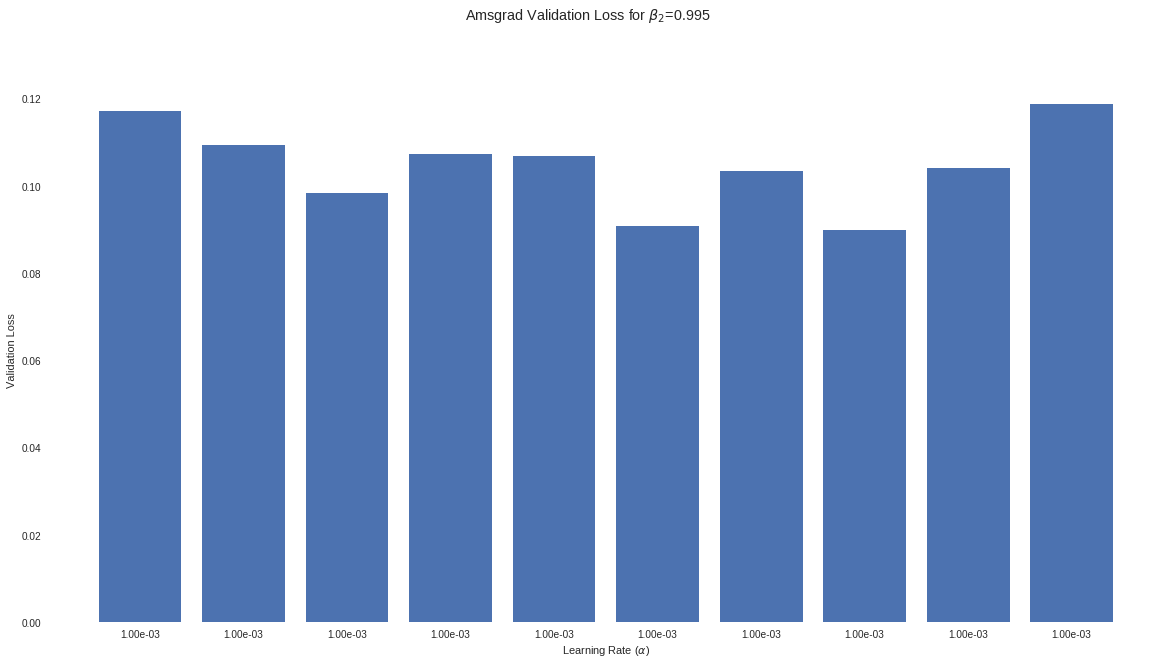

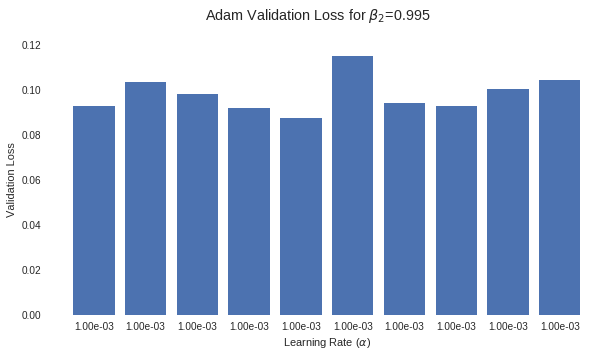

In [117]:

# Graphing the validation performance


x = []
y = []

vals = []

plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()



for i in range(len(train_loss_list)):
  x.append("{:.2e}".format(train_loss_list[i][1]))
  y.append(train_loss_list[i][3])
  
fig.suptitle(r'Amsgrad Validation Loss for $\beta_2$=0.995')
plt.bar(np.arange(0,len(y)), y)
ax.set_xticks(np.arange(0,len(x)))
ax.set_xticklabels(x)
fig.gca().set_facecolor('w')
ax.set_ylabel('Validation Loss')
ax.set_xlabel(r'Learning Rate ($\alpha$)')
plt.show()


plt.rcParams["figure.figsize"] = (10,5)
fig, ax = plt.subplots()

x = []
y = []

vals = []

for i in range(len(train_loss_adam_list)):
  vals.append((train_loss_adam_list[i][1], train_loss_adam_list[i][3]))
  
vals.sort(key=lambda x: x[0])

for i in range(len(train_loss_list)):
  x.append("{:.2e}".format(train_loss_adam_list[i][1]))
  y.append(train_loss_adam_list[i][3])
  
fig.suptitle(r'Adam Validation Loss for $\beta_2$=0.995')
plt.bar(np.arange(0,len(y)), y)
ax.set_xticks(np.arange(0,len(x)))
ax.set_xticklabels(x)
fig.gca().set_facecolor('w')
ax.set_ylabel('Validation Loss')
ax.set_xlabel(r'Learning Rate ($\alpha$)')
plt.show()

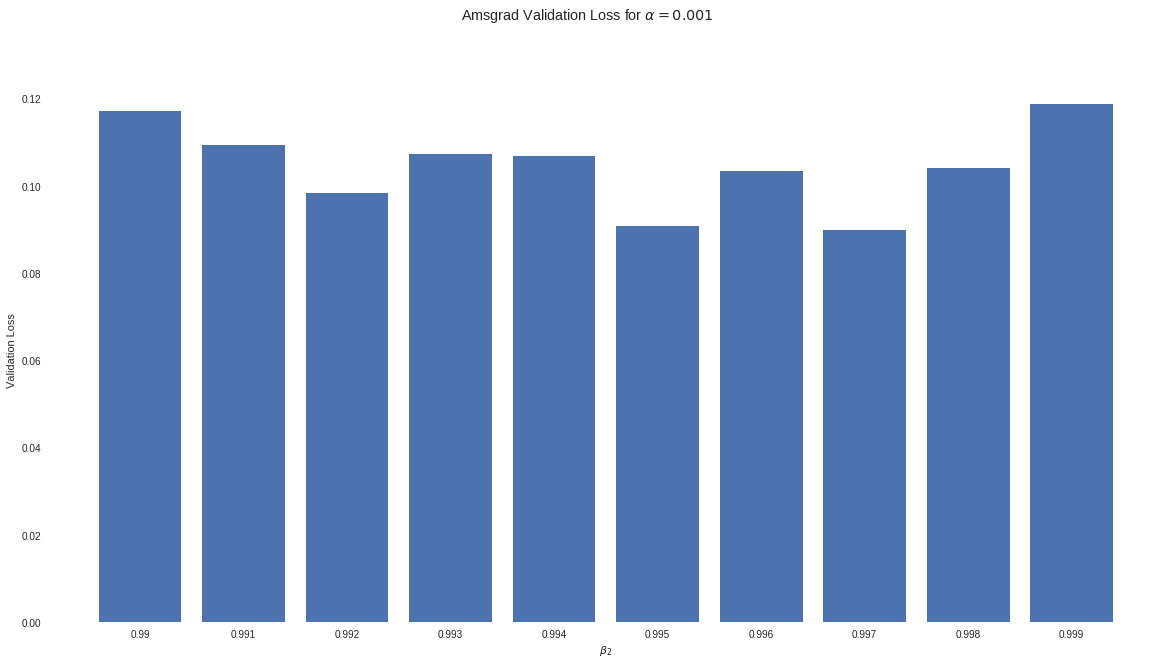

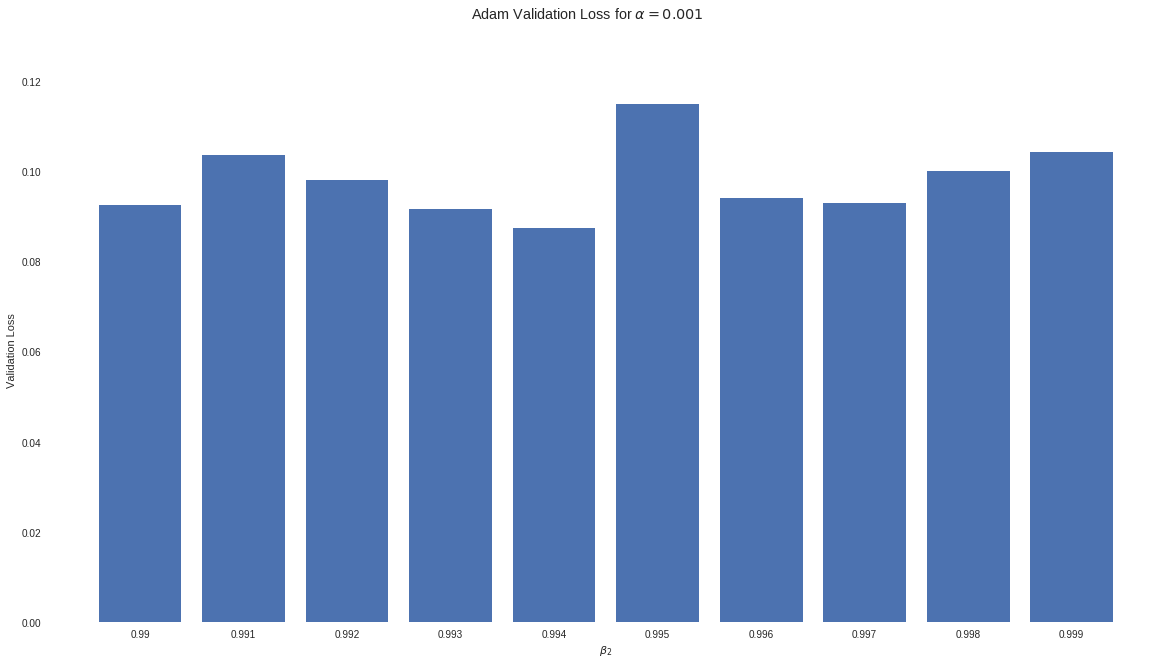

In [125]:
# Graphing the validation performance

x = []
y = []

vals = []

plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()


for i in range(len(train_loss_list)):
  vals.append((train_loss_list[i][2], train_loss_list[i][3]))
  
vals.sort(key=lambda x: x[0])

for i in range(len(vals)):
  x.append(vals[i][0])
  y.append(vals[i][1])
  
fig.suptitle(r'Amsgrad Validation Loss for $\alpha=0.001$')
plt.bar(np.arange(0,len(y)), y)
ax.set_xticks(np.arange(0,len(x)))
ax.set_xticklabels(x)
fig.gca().set_facecolor('w')
ax.set_ylabel('Validation Loss')
ax.set_xlabel(r'$\beta_2$')
plt.show()


plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()

x = []
y = []

vals = []

for i in range(len(train_loss_adam_list)):
  vals.append((train_loss_adam_list[i][1], train_loss_adam_list[i][3]))
  
vals.sort(key=lambda x: x[0])

for i in range(len(train_loss_list)):
  x.append(train_loss_adam_list[i][2])
  y.append(train_loss_adam_list[i][3])
  
fig.suptitle(r'Adam Validation Loss for $\alpha=0.001$')
plt.bar(np.arange(0,len(y)), y)
ax.set_xticks(np.arange(0,len(x)))
ax.set_xticklabels(x)
fig.gca().set_facecolor('w')
ax.set_ylabel('Validation Loss')
ax.set_xlabel(r'$\beta_2$')
plt.show()

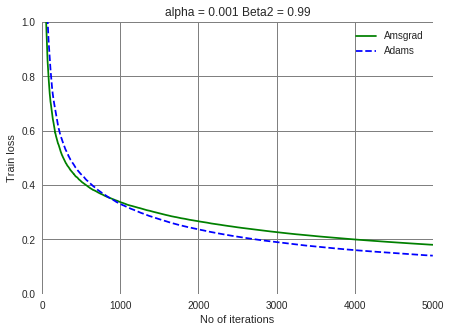

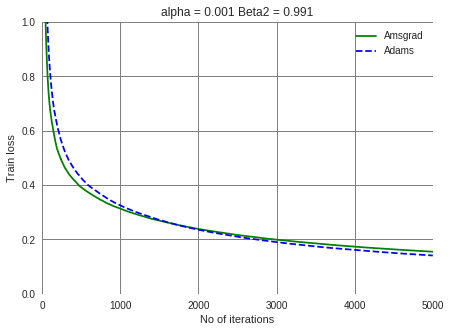

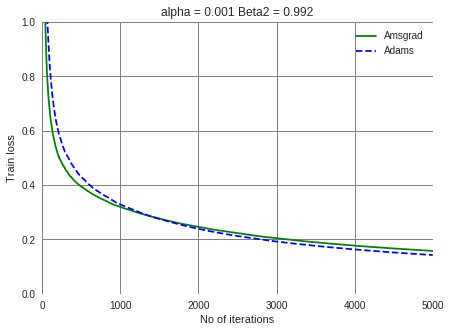

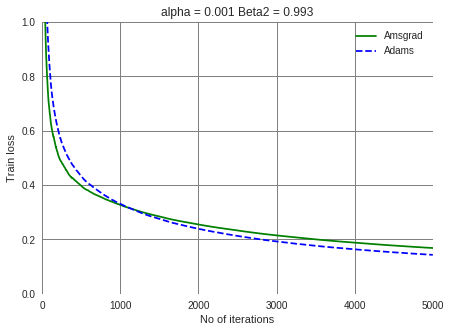

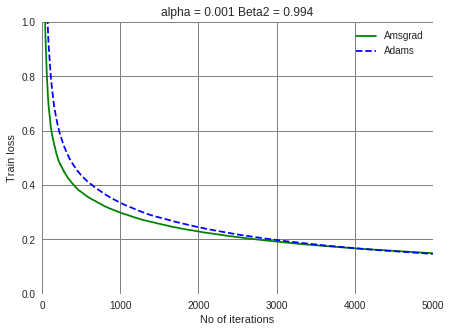

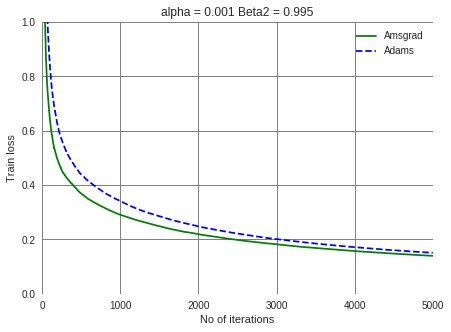

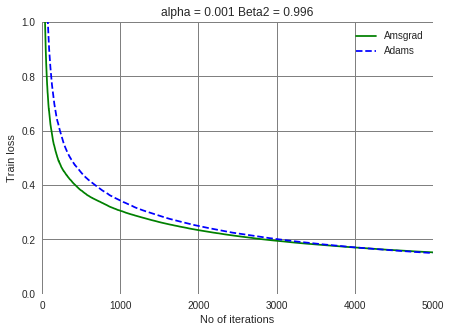

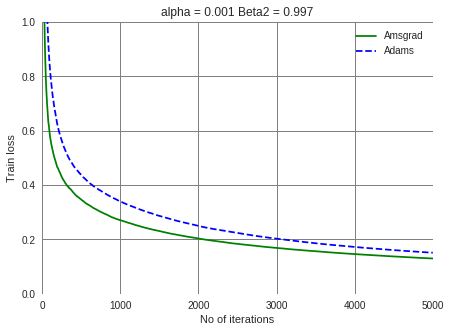

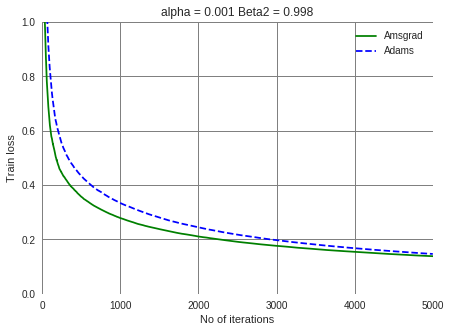

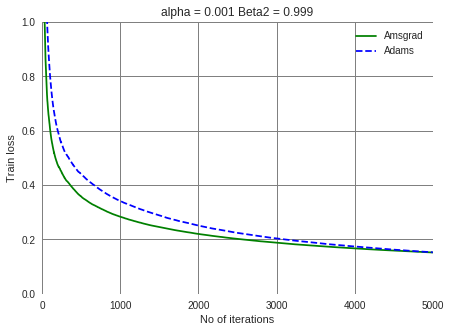

In [116]:
# Graphing performance of Neural Network

x = np.linspace(0,5000,len(train_loss_adam_list[0][0]))

for i in range(len(train_loss_adam_list)):
  
  plt.figure(figsize=(7,5))
  title = "alpha = " + str(train_loss_adam_list[i][1]) + " Beta2 = " + str(train_loss_adam_list[i][2])
  plt.title(title)
  plt.plot(x, train_loss_list[i][0], 'g', label="Amsgrad")
  plt.plot(x, train_loss_adam_list[i][0], 'b--', label ="Adams")
  plt.ylim(0,1)
  plt.xlim(0,5000)
  plt.grid(color='gray', linewidth=1)
  plt.gca().set_facecolor('w')
  plt.legend(loc='best')
  plt.xlabel('No of iterations')
  plt.ylabel('Train loss')
  plt.show()